In [1]:

# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LinearRegression as LM
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [2]:
dat= pd.read_csv("cleanind.csv")
dat.dtypes

VETERAN3                          float64
SEXVAR                              int64
_URBSTAT                          float64
lgbtq                               int64
dis                                 int64
_AGE_G                            float64
_EDUCAG                           float64
jobhaver                            int64
INCOME2                           float64
PERSDOC2                          float64
CHECKUP1                          float64
LASTDEN4                          float64
MEDCOST                           float64
HLTHPLN1                          float64
GENHLTH                           float64
_SMOKER3                          float64
_DRNKWK1                          float64
EXERANY2                          float64
_LTASTH1                          float64
ADDEPEV3                          float64
aces                              float64
state                              object
avgqoc                            float64
married                           

In [ ]:
dat['dis'].value_counts()

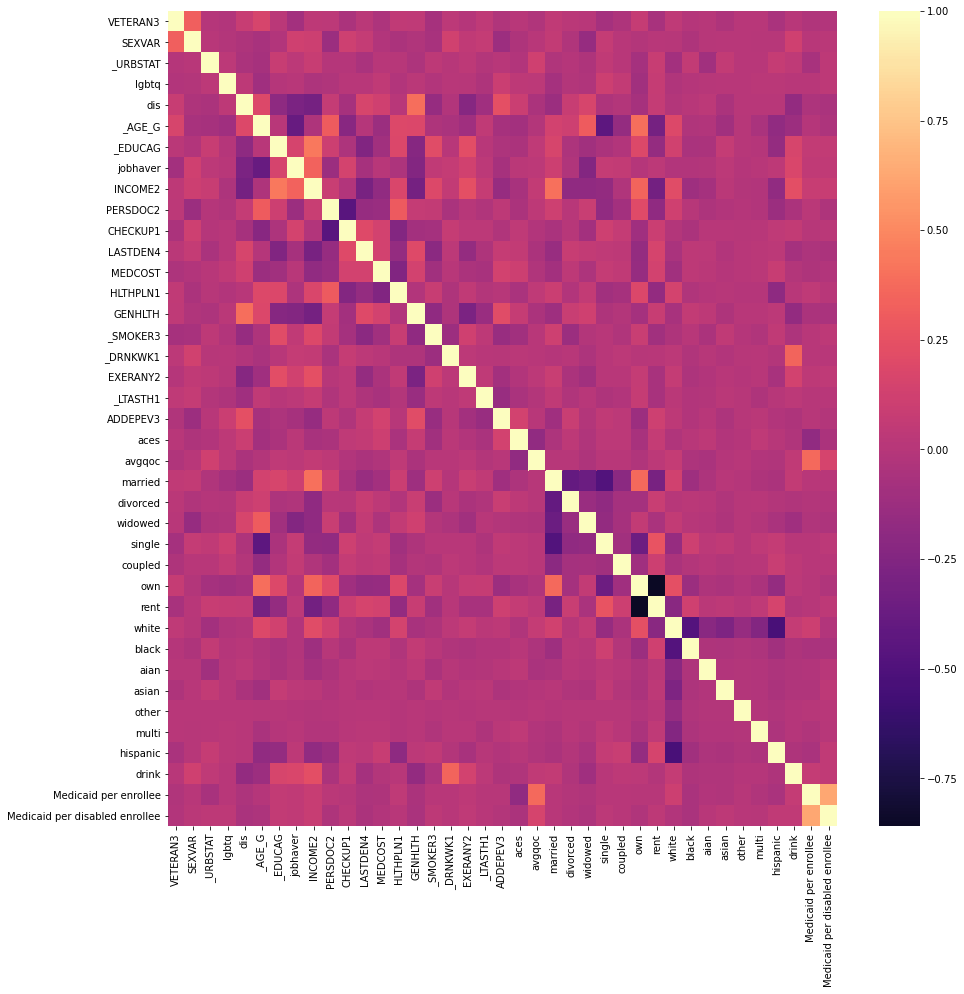

In [4]:
M = dat.select_dtypes(include=["int64", "float64"]).corr()

#plotting the float variables' correlations found above as a heat map
plt.figure(figsize = (15,15))
sns.heatmap(M, center=0,cmap="magma")
plt.show()

In [ ]:
(
    ggplot(dat,aes(x = "state",y='GENHLTH', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "health rating/disability",
          x= "state",
          y= "health rating")
)

In [5]:
dat.filter(['dis','GENHLTH']).groupby(['dis']).mean(['GENHLTH'])

,GENHLTH
dis,
0,2.183983
1,3.124372


In [ ]:
#dat.filter(['employed','selfemployed','worklessover1','worklessunder1','student','retired','unable','GENHLTH']).groupby(['employed','selfemployed','worklessover1','worklessunder1','student','retired','unable']).mean(['GENHLTH'])

In [ ]:
#dat.filter(['dis','unable']).groupby(['dis']).sum(['unable'])

In [6]:
dat.filter(['dis','_AGE_G']).groupby(['dis']).sum(['_AGE_G'])

,_AGE_G
dis,
0,1214424.0
1,533468.0


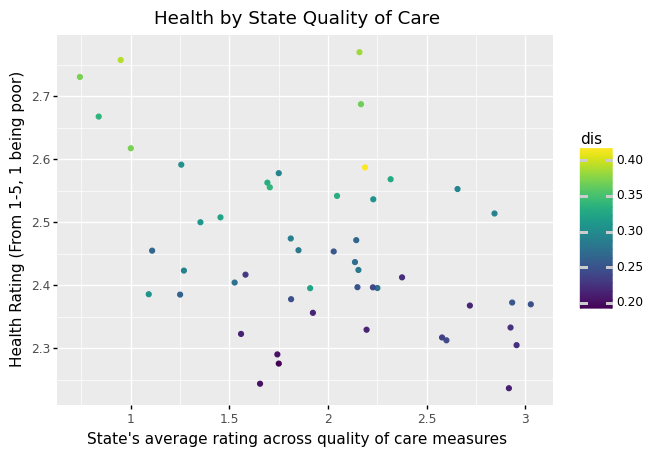

<ggplot: (144461295869)>

In [7]:
#plotting quality of care
stategrp = (dat
       .groupby(["state"])
       .mean(["GENHLTH",'avgqoc'])
       .reset_index()
      )

(
    ggplot(stategrp,aes(x = "avgqoc",y='GENHLTH', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "Health by State Quality of Care",
          x= "State's average rating across quality of care measures",
          y= "Health Rating (From 1-5, 1 being poor)")
)

In [10]:
dat = dat.dropna()
#splitting data after processing 
y = dat[['GENHLTH']]
X = dat.drop(columns=['GENHLTH','state','_DRNKWK1'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [11]:


# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

search_space = [
    
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]



search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search.fit(train_X,train_y.GENHLTH)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [12]:
search.best_score_

-0.7714168782731686

In [13]:
search.best_params_

{'model': LinearRegression()}

In [14]:
rf_mod = search.best_estimator_

In [8]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])


AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [17]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

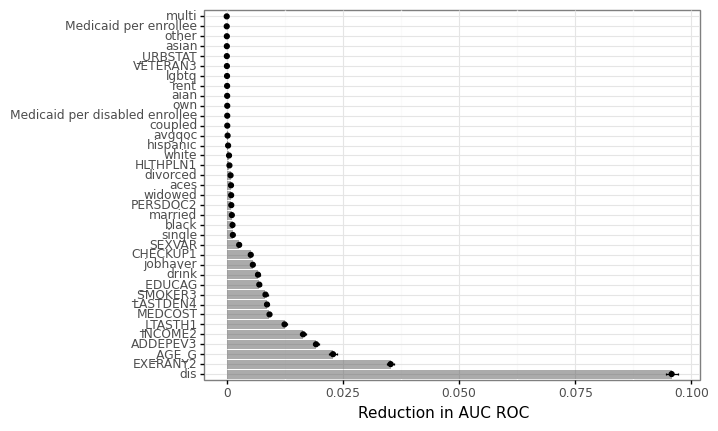

<ggplot: (112408992762)>

In [15]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)



# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)




# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [17]:
disabled = dat[dat['dis']==1]
abled = dat[dat['dis']==0]

In [18]:
#splitting data after processing 
y = disabled[['GENHLTH']]
X = disabled.drop(columns=['GENHLTH','state','_DRNKWK1'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)



# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

search_space = [
    
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]



search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search.fit(train_X,train_y.GENHLTH)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [19]:
search.best_score_

-0.9647032479570965

In [20]:
search.best_params_

{'model': LinearRegression()}

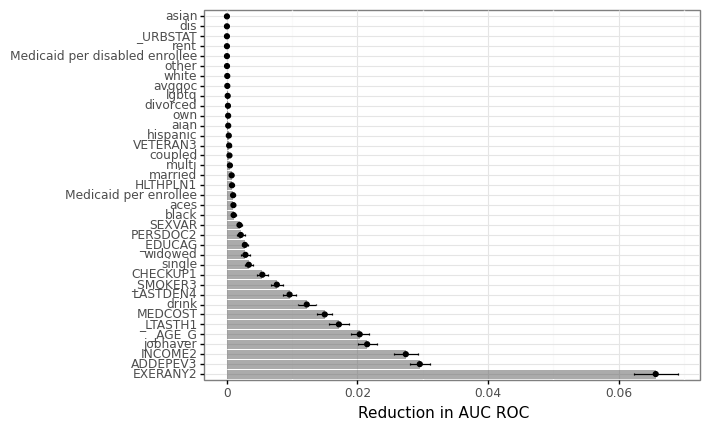

<ggplot: (112404186347)>

In [21]:
rf_mod = search.best_estimator_

vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)



# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)




# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [22]:
#splitting data after processing 
y = abled[['GENHLTH']]
X = abled.drop(columns=['GENHLTH','state','_DRNKWK1'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)



# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

search_space = [
    
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]



search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search.fit(train_X,train_y.GENHLTH)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [23]:
search.best_score_

-0.6911859195079072

In [24]:
search.best_params_

{'model': LinearRegression()}

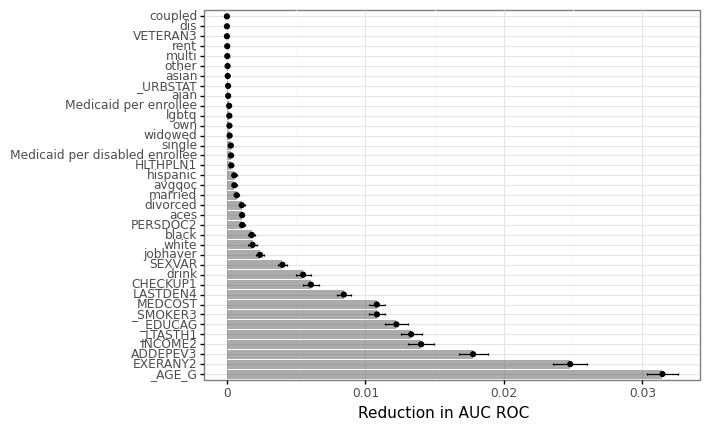

<ggplot: (112409381051)>

In [25]:
rf_mod = search.best_estimator_

vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)



# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)




# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)